In [1]:
%load_ext autoreload
%autoreload 2
import sys
if "../src" not in sys.path:
    sys.path.append("../src")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm.auto import tqdm
from vec4gloss import check_hashes  

## Data dependencies

```
32.22 => ..\data\token-params-annot.csv d75ff
```

In [3]:
data_path = "../data/token-params-annot.csv"
_ = check_hashes([data_path])

..\data\token-params-annot.csv d75ff7


## Load resources

In [4]:
raw_data = pd.read_csv(data_path)
n_types = raw_data[["type", "frame_idx"]]\
    .groupby("type")\
    .agg(n=("frame_idx", len))\
    .query("n>24.4 and type!='--'")    

In [5]:
#  how many data is kept (~60%)
n_types.n.sum()/raw_data.shape[0]

0.5933701657458563

In [6]:
data = raw_data.loc[raw_data.type.isin(n_types.index), :]

In [7]:
def list_type_text(chunk_type):
    return " ".join(data.loc[data.type==chunk_type, "text"].tolist())

In [8]:
list_type_text("noun")

'預期中 條件 預期 預期 足夠的時間 預期的效果 任何限制 其他媒介 受特定條件的限制 能力或條件不夠的情況 條件 其他媒介 趣味 頻率 疑問 肯定 現場 道理 相同動作 時段 間隔 預期 合理條件 假設的時間 主觀評價 前述描述 後述描述 目的 後述變化 立場 比例 機會 個人意願 能力 能力 後述時間或狀況 要求 重要影響 預期效果 能力 需要的時候 必要條件 可能性 願望 必要 條件 他人 語氣'

In [9]:
list_type_text("action")

'去做 體驗 達到 成立 完成 發生 做 做 做 發生 進行 持續 進行 產生 進行 進行 涉及 設定 做 做到 做 進行 從事 進行 接 發生 做 進行 他人知道 達到 成立 做 做 發生 做 出現 發生 發生 發生 確定 詢問原因 持續 發生 發生 發生 涵蓋 改變 發展 造成 包含 直接參與 發生 進行 觀察到 做 發展 做 發生 發生 發生 發生 發生 驚訝 完成 影響 進行 發生 做 預測 發生 強調 繼續 開始 令人感到意外 同時 發生 發生 發生 發生過 發生 發生 經過 成立 變化 實際 持續 間斷 達到 發展到 發生 實現 牽涉 強調 發生 已達成 發生 發生 發生 表達 發生 競爭以取得 做 做 做 肯定 完成 進展 完成 想辦法 完成 利用 進行 進行 提出 進行 進行 說話 發生或完成 預期 發生 發生 存在 進行 達到 做 允許 發生 發生 發生過 導致 做 做 經歷 堅持進行 進行 進行 進行 進行 做 發生 做 做 完成 實現 做 做 認為 做 做 完成 影響到 成立 進行 進行 請求 進行 接續 作評價 肯定'

In [10]:
action_words = list_type_text("action").split()

In [11]:
from collections import Counter
Counter(action_words).most_common(3)

[('發生', 34), ('做', 25), ('進行', 21)]

In [12]:
(34+25+21)/len(action_words)

0.5031446540880503

In [13]:
list_type_text("scope")

'在 在 比 只 在 之中 對 在 下 在 之後 在 下 只 在 中 於 對 從 到 在 中 在 中 自 至 對 在 對 在 上 在 之前 到 對 在 中 在 中 在 從 到 在 內 從 和 比 後 比 對 針對 在 內 在 對 在 前 對 在 之前 在 內 從 對 對 在 對'

In [14]:
list_type_text("neg")

'不 沒有 不 沒有 未 不 不 不 不 不必 沒有 不 沒有 非 非 不 不 無法 不 不 不長 還沒 不 不 不 不 無法 沒有 不 沒有 不 沒有 不 否定'

In [15]:
def rename_types(x):
    lut = {"mod": "modifier", "neg": "negation", "noun": "others", "scope": "preposition"}
    return lut.get(x, x).capitalize()

In [16]:
se = lambda x: np.std(x, ddof=1)/np.sqrt(len(x))
pdata = data.drop(["frame_idx", "text", "event_role"], axis=1)\
    .groupby("type")\
    .agg(
        n=("semanticness", len),
        sem_mean=("semanticness", "mean"),
        sem_se=("semanticness", se),        
        ctx_mean=("contextualness", "median"),
        ctx_se=("contextualness", se),                
    )
pdata = pdata.rename(index=rename_types)

In [17]:
pdata

,n,sem_mean,sem_se,ctx_mean,ctx_se
type,,,,,
Action,159,0.795750,0.214103,2.720058,0.337937
Event,162,0.529399,0.191673,0.295381,0.168197
Modifier,67,1.342227,0.342857,0.688785,0.436811
Negation,34,1.808706,0.445273,1.651243,0.563257
Others,48,1.509666,0.325951,3.152485,0.450864
Preposition,67,2.000944,0.404220,1.540626,0.504350


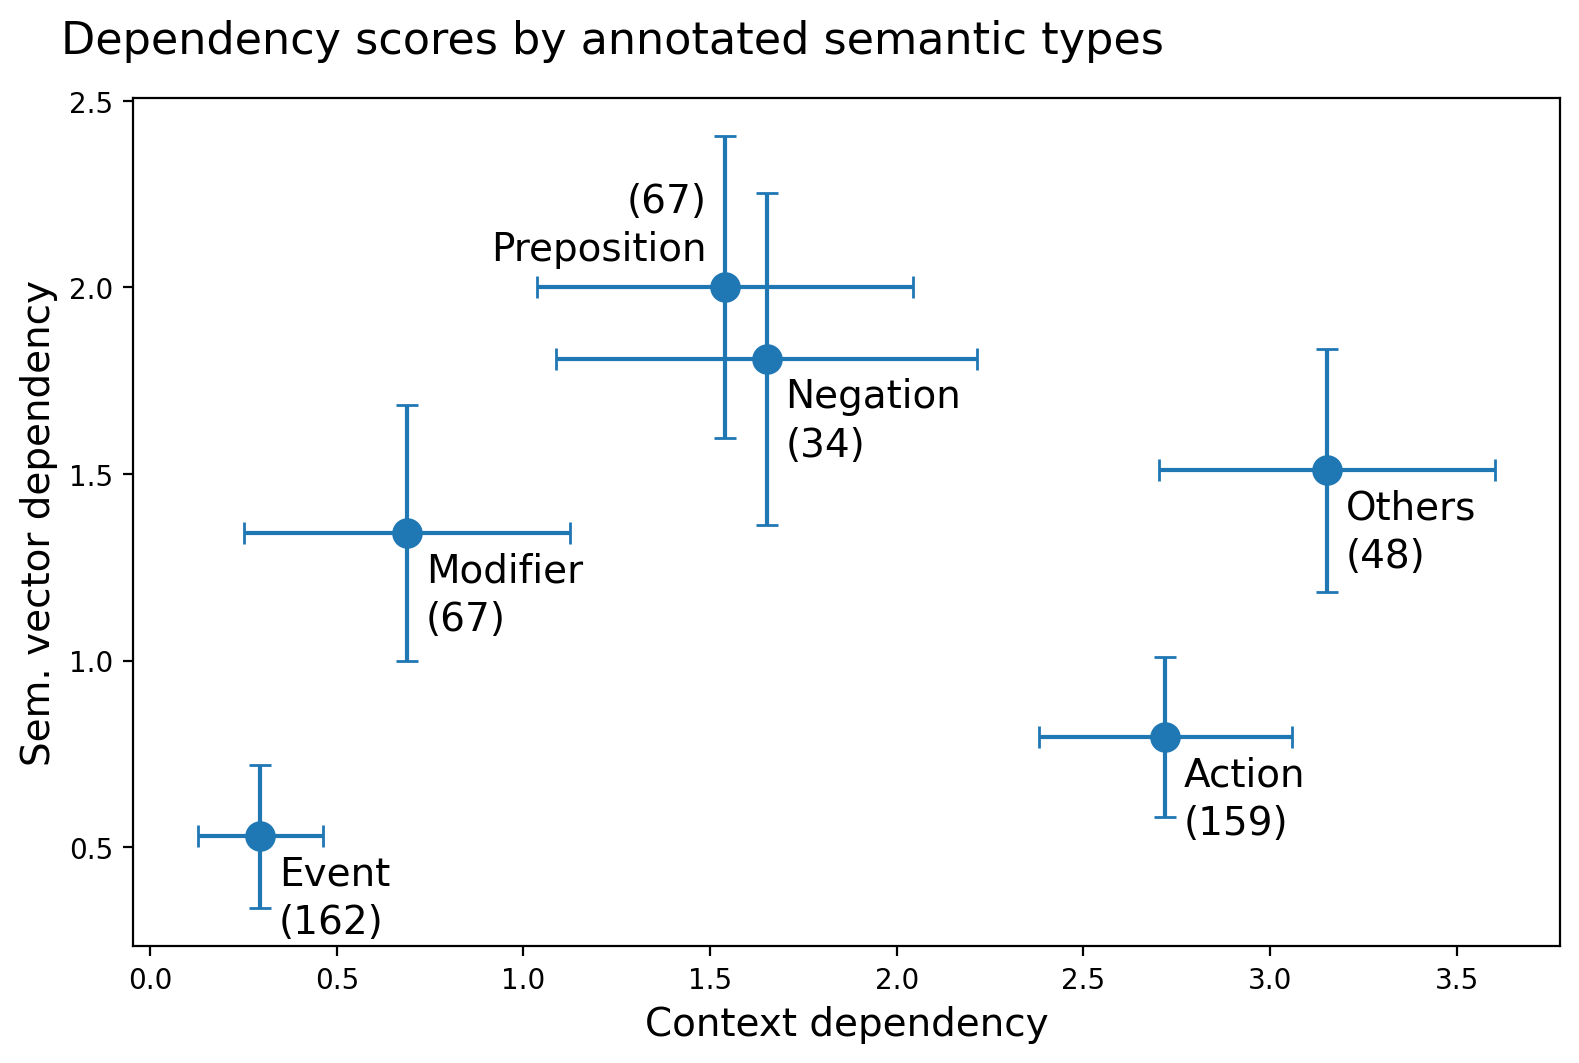

In [18]:
cmap = cm.get_cmap("tab20")
fig = plt.figure(figsize=(8,6), dpi=200)
plt.errorbar(pdata.ctx_mean, pdata.sem_mean, 
             xerr=pdata.ctx_se,
             yerr=pdata.sem_se, fmt='.', capsize=4)
plt.plot(pdata.ctx_mean, pdata.sem_mean, '.', markersize=20, color=cmap(0))
for ridx, row in pdata.iterrows():
    if ridx=="Preposition":
        x = row.ctx_mean-.05; y = row.sem_mean+.05
        nx = row.ctx_mean-.05; ny = row.sem_mean+.18
        ha = "right"; va = "bottom"        
    else:
        x = row.ctx_mean+.05; y = row.sem_mean-.05
        nx = row.ctx_mean+.05; ny = row.sem_mean-.18
        ha = "left"; va = "top"        
    plt.text(x, y, ridx, 
             ha=ha, va=va,
             fontsize=14)    
    plt.text(nx, ny, f"({int(row.n):d})", 
             ha=ha, va=va,
             fontsize=14)
plt.gca().set_aspect("equal")
plt.xlabel("Context dependency", fontsize=14)
plt.ylabel("Sem. vector dependency", fontsize=14)
plt.title("Dependency scores by annotated semantic types", 
          fontsize=16,
          ha="left", position=(-.05,1), pad=16)
plot_path = "../data/plots/90.12-chunk-types.png"
plt.tight_layout()
fig.savefig(plot_path)

## Ouput Hashes

```
..\data\plots\90.12-chunk-types.png 39ceee
```

In [19]:
_ = check_hashes(plot_path)

..\data\plots\90.12-chunk-types.png 39ceee
